# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

## References

* HAT-P-14 b [(Fukui+16a))](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'moscatel'

In [3]:
import os
from glob import glob
import getpass

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

In [4]:
from moscatel import utils

bands = utils.get_band_list(file_list);

100%|██████████| 1456/1456 [00:04<00:00, 337.38it/s]

g-band: 376 frames
r-band: 704 frames
z_s-band: 376 frames


## Stack (some) raw images

In [5]:
from moscatel import utils

stacked_images = []
for key in bands.keys():
    stacked_images.append(utils.stack_raw_images(bands[key], skip_every=10))

 20%|█▉        | 14/71 [00:00<00:00, 132.19it/s]

number of stacked raw images=38


 42%|████▏     | 16/38 [00:00<00:00, 151.02it/s]

number of stacked raw images=71


100%|██████████| 38/38 [00:00<00:00, 149.54it/s]


number of stacked raw images=38


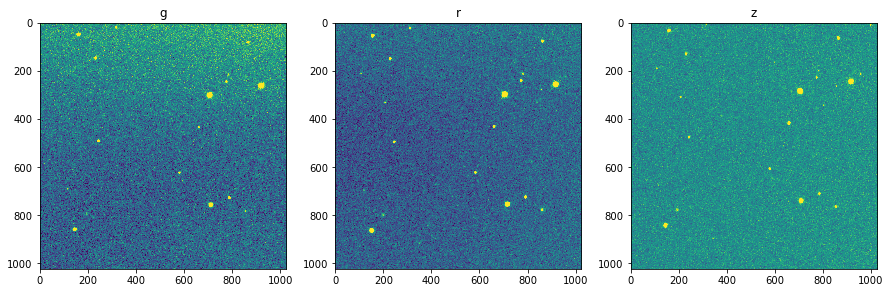

In [6]:
from moscatel import utils
%matplotlib inline

utils.show_stacked_images(stacked_images)

## Detect point sources

In [7]:
from moscatel import phot

sources = []

for idx, img in enumerate(stacked_images):
    sources.append(phot.get_sources(img, num_stars=10))

In [8]:
len(sources) #g,r,z_s

3

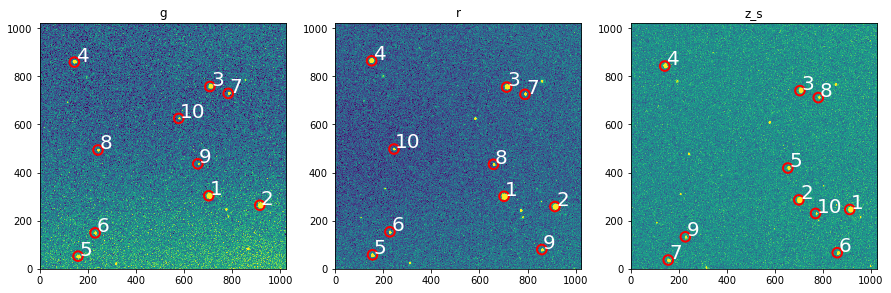

In [9]:
from moscatel import plotting

plotting.show_sources(stacked_images, sources, list(bands.keys()), num_stars=10)

note that star 1 and 2 is different in g-band.

## check centroids per band

In [10]:
idx=2; #0:g, 1:r, 2:z_s

centroids_z = list(zip(sources[idx]['xcentroid'],sources[idx]['ycentroid']))
centroids_z

[(911.39188437197015, 246.12980190879145),
 (699.53750528700039, 286.07443110839995),
 (704.18187575311833, 740.5490320830886),
 (141.80924549407234, 842.84580377023428),
 (653.85638215459551, 418.63573919508372),
 (859.36693469398904, 66.36230497279108),
 (156.35359259552808, 35.961899225903849),
 (780.52429513019206, 711.64434136869272),
 (227.51527885090604, 132.5599346235625),
 (769.15088423000464, 229.7939819925989)]

there is problem in stars detection near edges

## check if such centroids coincide for all stars in one sample image

sample image

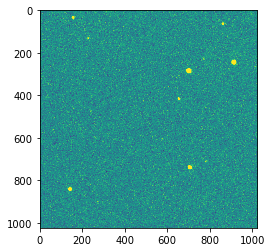

In [11]:
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

sample_img = pf.open(bands['z_s'][0])[0].data
vmin,vmax= ZScaleInterval().get_limits(sample_img)
plt.imshow(sample_img,vmin=vmin,vmax=vmax)

In [12]:
centroids_g = list(zip(sources[0]['xcentroid'],sources[0]['ycentroid']))
centroids_r = list(zip(sources[1]['xcentroid'],sources[1]['ycentroid']))
centroids_z = list(zip(sources[2]['xcentroid'],sources[2]['ycentroid']))

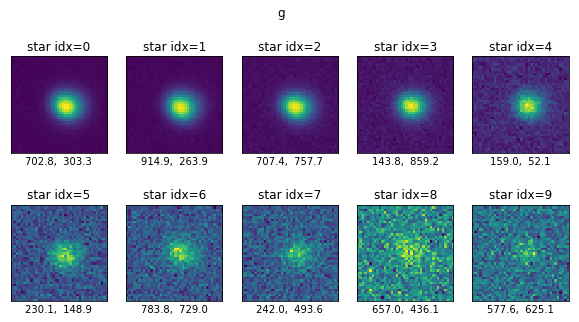

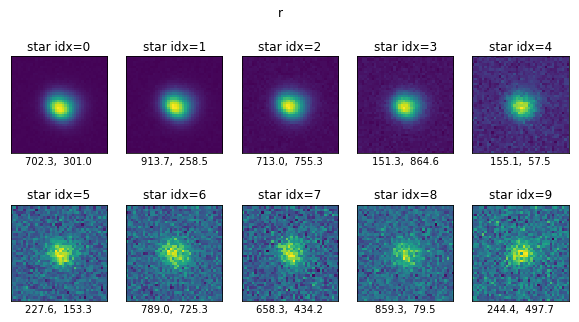

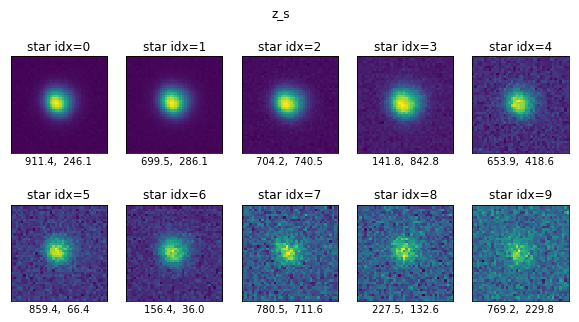

In [13]:
import warnings

star_id = 0 #first, brightest

#-----------gband-------------#
fig = plt.figure(figsize=(10,5))
sample_img = pf.getdata(bands['g'][star_id])

for i,xy in enumerate(centroids_g[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        ax = plt.subplot(2,5,i+1)
    except:
        warnings.warn('star not cropped')
    ax.set_title('star idx={}'.format(i))
    ax.imshow(img_crop)
    ax.set_xlabel('{0:.1f},  {1:.1f}'.format(xy[0],xy[1]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('g')

#-----------rband-------------#
fig = plt.figure(figsize=(10,5))
sample_img = pf.getdata(bands['r'][star_id])

for i,xy in enumerate(centroids_r[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        ax = plt.subplot(2,5,i+1)
    except:
        warnings.warn('star not cropped')
    ax.set_title('star idx={}'.format(i))
    ax.imshow(img_crop)
    ax.set_xlabel('{0:.1f},  {1:.1f}'.format(xy[0],xy[1]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('r')

#-----------zband-------------#
fig = plt.figure(figsize=(10,5))
sample_img = pf.getdata(bands['z_s'][star_id])

for i,xy in enumerate(centroids_z[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        ax = plt.subplot(2,5,i+1)
    except:
        warnings.warn('star not cropped')
    ax.set_title('star idx={}'.format(i))
    ax.imshow(img_crop)
    ax.set_xlabel('{0:.1f},  {1:.1f}'.format(xy[0],xy[1]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('z_s')

## check if one centroid $n$ coincide with (all) images in each band

try changing `skip_every`

(-0.5, 59.5, 59.5, -0.5)

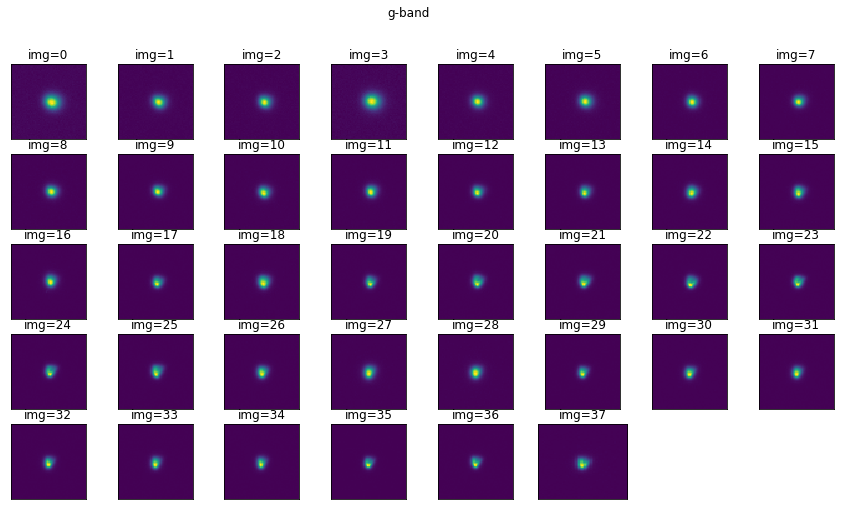

In [14]:
skip_every=10

fig = plt.figure(figsize=(15,8))

num=0
centroids_g = list(zip(sources[num]['xcentroid'],sources[num]['ycentroid']))

rows=8
cols=round(len(bands['g'][::skip_every])/rows)
    
for idx,i in enumerate(bands['g'][::skip_every]):
    img=pf.getdata(i)
    try:
        img_crop = utils.get_crop(img, centroids_g[0], box_size=60)
        ax = plt.subplot(cols,rows,idx+1)
    except:
        warnings.warn('star not cropped')
    ax.set_title('img={}'.format(idx))
    ax.imshow(img_crop)
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('g-band')
plt.axis('tight')

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: star not cropped


(-0.5, 59.5, 59.5, -0.5)

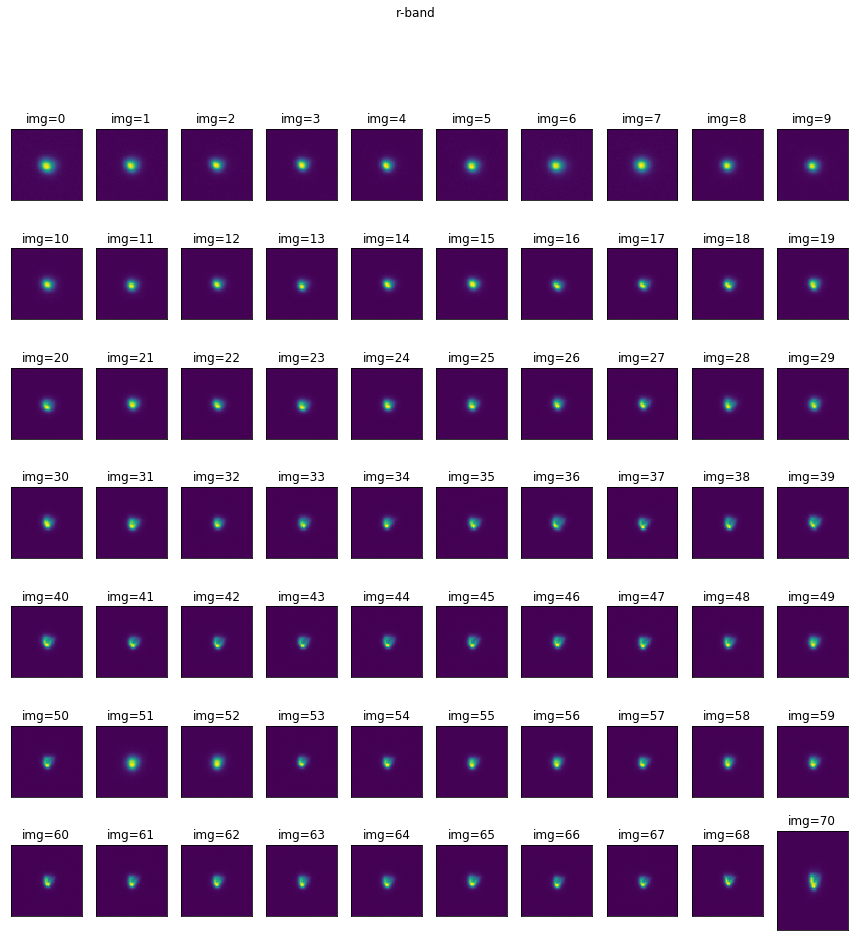

In [15]:
skip_every=10

fig = plt.figure(figsize=(15,15))

num=1 #r
centroids_r = list(zip(sources[num]['xcentroid'],sources[num]['ycentroid']))

band='r'
rows=10
cols=round(len(bands[band][::skip_every])/rows)
    
for idx,i in enumerate(bands[band][::skip_every]):
    img=pf.getdata(i)
    try:
        img_crop = utils.get_crop(img, centroids_r[0], box_size=60)
        ax = plt.subplot(cols,rows,idx+1)
    except:
        warnings.warn('star not cropped')
    ax.set_title('img={}'.format(idx))
    ax.imshow(img_crop)
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('{}-band'.format(band))
plt.axis('tight')

(-0.5, 59.5, 59.5, -0.5)

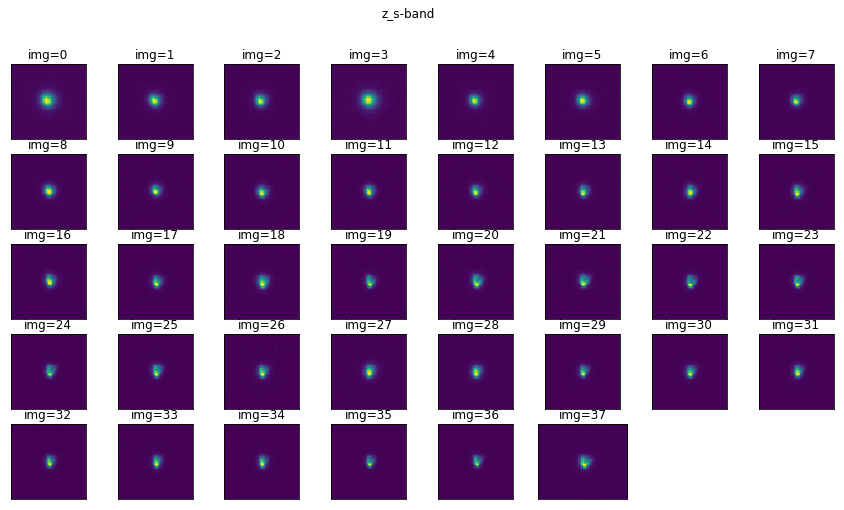

In [16]:
skip_every=10

num=2 #r
centroids_z = list(zip(sources[num]['xcentroid'],sources[num]['ycentroid']))

fig = plt.figure(figsize=(15,8))
band='z_s'
rows=8
cols=round(len(bands[band][::skip_every])/rows)
    
for idx,i in enumerate(bands[band][::skip_every]):
    img=pf.getdata(i)
    try:
        img_crop = utils.get_crop(img, centroids_z[0], box_size=60)
        ax = plt.subplot(cols,rows,idx+1)
    except:
        warnings.warn('star not cropped')
    ax.set_title('img={}'.format(idx))
    ax.imshow(img_crop)
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('{}-band'.format(band))
plt.axis('tight')

## 1D psf modeling

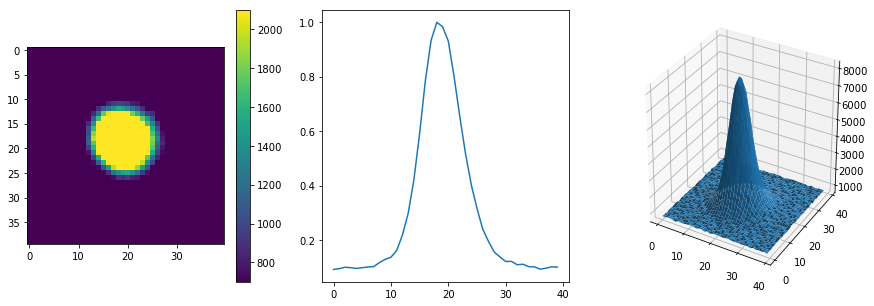

In [17]:
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

sample_img = pf.open(bands['z_s'][0])[0].data
img_crop=utils.get_crop(sample_img,centroids_z[0],box_size=40)

mean, median, stddev=sigma_clipped_stats(sample_img)

vmin,vmax= ZScaleInterval().get_limits(img_crop)

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(131)
im=ax0.imshow(img_crop-median,vmin=vmin,vmax=vmax)
fig.colorbar(im,ax=ax0)

xslice=img_crop[20,:]
ax1 = fig.add_subplot(132)
ax1.plot(xslice/np.max(xslice))

ax2 = fig.add_subplot(133, projection='3d')
#ax = plt.gca(projection='3d')
xx,yy=np.mgrid[0:img_crop.shape[0],0:img_crop.shape[1]]

ax2.plot_surface(X=xx, Y=yy, Z=img_crop[yy,xx])

In [18]:
fwhm_estimate = 10 #pix
sigma_estimate = fwhm_estimate/2.355
sigma_estimate

4.246284501061571

A: 0.9022142557795813
mu: 18.633295322224225
sigma= 3.55775695191886
eps: 0.10095964330190349


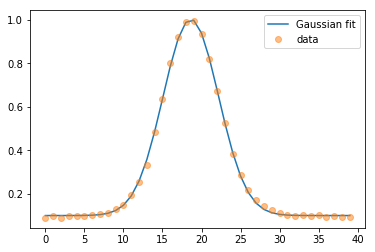

In [19]:
from moscatel import models

sample_img = pf.open(bands['z_s'][0])[0].data
img_crop=utils.get_crop(sample_img,centroids_z[0],box_size=40)

fit_result = models.model_gaussian(img_crop,verbose=True,show_fit=True);

with convolution

A: 0.8058084627050062
mu: 18.70822494505327
sigma= 5.478154667832574
eps: 0.19402609623923642


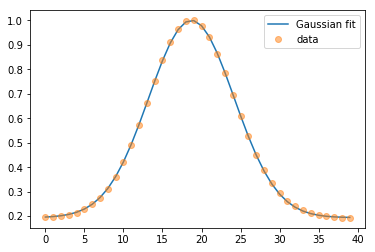

In [20]:
fit_result = models.model_gaussian(img_crop,convolve=True,verbose=True,show_fit=True);

4.04105924272
4.00247638446
3.96321175685
3.82506934781
0.0892406702042
0.0414096191525
0.0355126820505
0.0260604433715
0.0178680457175
0.0206288937479


/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


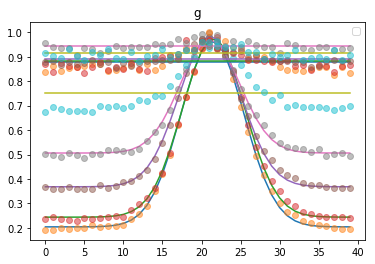

In [21]:
from moscatel import models

#check sigma of all stars in gband
band='g'
sample_img = pf.getdata(bands[band][0])

for i,xy in enumerate(centroids_g[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        fit_result = models.model_gaussian(img_crop,show_fit=True)
        print(fit_result[2]) #sigma
    except:
        warnings.warn('no good fit')
plt.title('{}'.format(band))
plt.legend([])

3.87767107536
3.75039031089
3.84623105785
3.83569133917
0.110014073551
0.0539399124682
0.0461960397661
0.0435239337385
0.0417395606637
0.0366695709527


/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


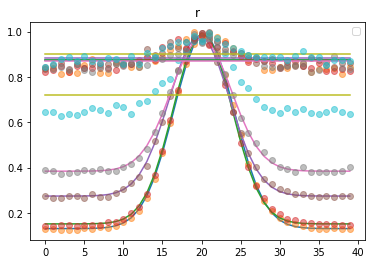

In [22]:
#check sigma of all stars in rband
band='r'
sample_img = pf.getdata(bands[band][0])

for i,xy in enumerate(centroids_r[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        fit_result = models.model_gaussian(img_crop,show_fit=True)
        print(fit_result[2]) #sigma
    except:
        warnings.warn('no good fit')
plt.title('{}'.format(band))
plt.legend([])

## check sigma of many stars in one sample image of each band

try `recenter = True` and other centroiding `methods=2D_gaussian,1D_gaussian,com`

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: 
star not cropped



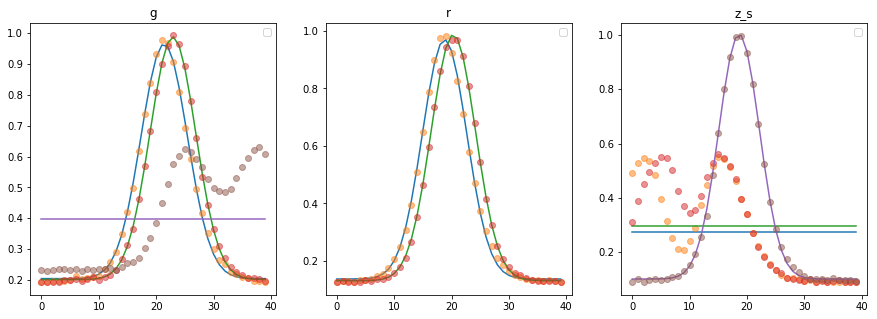

In [23]:
#check sigma of 5 stars in one image of each band
recenter = False

nstars=5
img_num = 0 #use first sample image
boxsize = 40

centroids = [centroids_g[0],centroids_r[0],centroids_z[0]]
sigmas = {}

fig = plt.figure(figsize=(15,5))

for idx, (key, centroid) in enumerate(list(zip(bands.keys(),centroids))):
    sigmas[key] = []
    #loop at different (ref) stars
    for xy in centroids[:nstars]:
        img=pf.getdata(bands[key][img_num])
        ax = plt.subplot(1,len(bands.keys()),idx+1)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, xy, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop, show_fit=True)
            sigmas[key].append(fit_result[2])

        except:
            warnings.warn('\nstar not cropped\n')
    plt.legend([])
    plt.title(key)

some non-gaussian and hence results in bad fit 

## Try convolving the faint (ref) stars

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


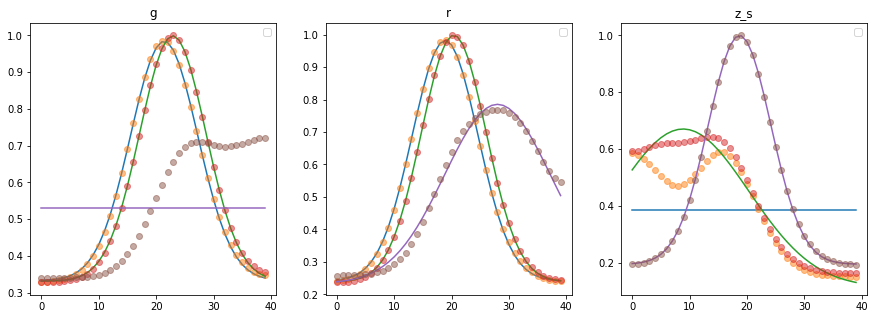

In [24]:
#check sigma of 5 stars in one image of each band
recenter = False

nstars=5
img_num = 0 #use first sample image
boxsize = 40

centroids = [centroids_g[0],centroids_r[0],centroids_z[0]]
sigmas = {}

fig = plt.figure(figsize=(15,5))

for idx, (key, centroid) in enumerate(list(zip(bands.keys(),centroids))):
    sigmas[key] = []
    #loop at different (ref) stars
    for xy in centroids[:nstars]:
        img=pf.getdata(bands[key][img_num])
        ax = plt.subplot(1,len(bands.keys()),idx+1)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, xy, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop, show_fit=True, convolve=True)
            sigmas[key].append(fit_result[2]) #sigma

        except:
            warnings.warn('star not cropped')
    plt.legend([])
    plt.title(key)

## check sigma of one star in $n$ number of images in each band (try convolving too)

try `recenter = True`, `convolve=True` and other centroiding `methods=2D_gaussian,1D_gaussian,com`

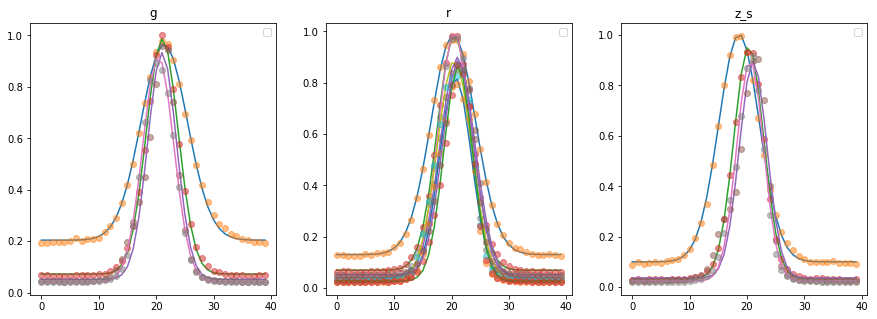

In [25]:
#check sigma of one star in many images each band
recenter = False

skip_every=100
star_id = 0 #first,brightest
centers = [centroids_g[star_id],centroids_r[star_id],centroids_z[star_id]]
boxsize = 40
sigmas = {}

fig = plt.figure(figsize=(15,5))

for idx,(key,centroid) in enumerate(list(zip(bands.keys(),centers))):
    sigmas[key] = []
    for i in bands[key][::skip_every]:
        img=pf.getdata(i)
        plt.subplot(1,3,idx+1)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, centroid, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop, show_fit=True)#, convolve=True)
            sigmas[key].append(fit_result[2]) #sigma

        except:
            warnings.warn('star not cropped')
    plt.legend([])
    plt.title(key)

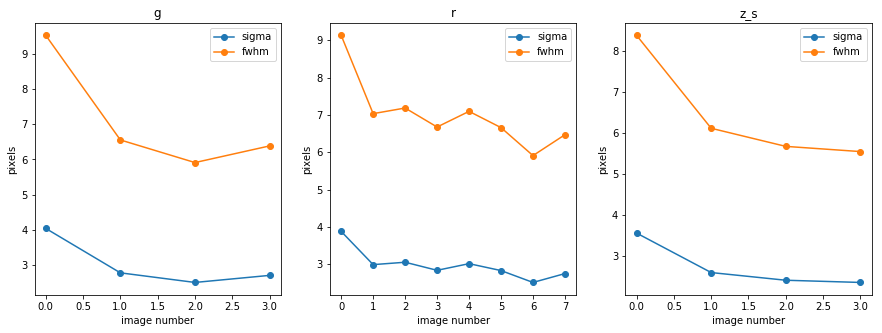

In [26]:
fig = plt.figure(figsize=(15,5))

for idx, key in enumerate(sigmas.keys()):
    ax=plt.subplot(1,3,idx+1)
    ax.plot(sigmas[key], 'o-', label='sigma')
    ax.plot(np.array(sigmas[key])*2.355, 'o-',label='fwhm')
    ax.set_title(key)
    ax.set_xlabel('image number')
    ax.set_ylabel('pixels')
    ax.legend()
    

## 2D psf modeling

### 2D Gaussian


Try `recenter=True`, `convolve=True` 

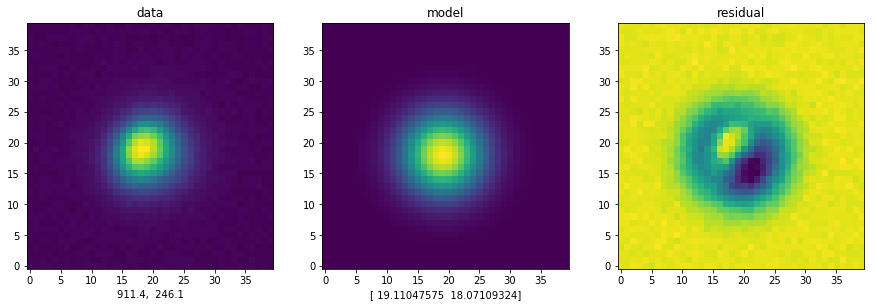

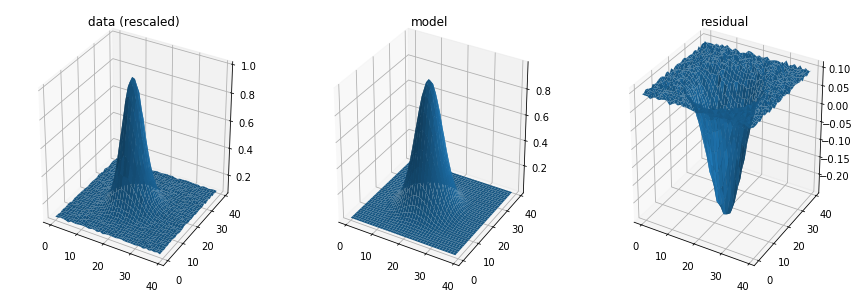

In [27]:
convolve = False
recenter = False
show_3D = True

from moscatel import models
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter
sigma_estimate = 4 #for gaussian_filter

star_id=0 #brightest
img_id = 0 #first
boxsize = 40
band = 'z_s' #depends on centroids_z below
sample_img = pf.open(bands[band][img_id])[0].data
centroid = centroids_z[star_id]

if convolve==True:
    sample_img = gaussian_filter(sample_img, sigma=sigma_estimate)

if recenter == True:
    #crop a bigger box first
    img_crop = utils.get_crop(img, centroid, box_size=80)
    #############RECENTROID#############
    xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

    #------------RE-CROP with smaller box------------#
    img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
else:
    img_crop = utils.get_crop(sample_img,centroid,box_size=boxsize)

fig = plt.figure(figsize=(15,5))

#define and fit model
g = models.model_gaussian2D(img_crop)

#data
ax1 = plt.subplot(1,3,1)
ax1.imshow(img_crop, origin='lower', interpolation='nearest')
ax1.set_title('data')
ax1.set_xlabel('{0:.1f},  {1:.1f}'.format(centroid[0],centroid[1])) #centroid x,y
#model
ax2 = plt.subplot(1,3,2)
ax2.imshow(g(yy,xx), origin='lower', interpolation='nearest')
ax2.set_title('model')
ax2.set_xlabel(g.param_sets[1:3].flatten()) #centroid x,y
#residual
ax3 = plt.subplot(1,3,3)
ax3.imshow(img_crop-g(yy,xx), origin='lower', interpolation='nearest')
ax3.set_title('residual')

'''
Take note of the 3D syntax: g(yy,xx)[yy,xx]
'''
if show_3D==True:
    xx,yy=np.mgrid[0:img_crop.shape[0],0:img_crop.shape[1]]

    fig = plt.figure(figsize=(15,5))
    #data
    img_crop_norm = img_crop/np.max(img_crop)
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X=xx, Y=yy, Z=img_crop_norm[yy,xx])
    ax1.set_title('data (rescaled)')
    #model
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X=xx, Y=yy, Z=g(yy,xx)[yy,xx])
    ax2.set_title('model')
    #residual
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X=xx, Y=yy, Z=(img_crop-g(yy,xx)[yy,xx]))
    ax3.set_title('residual')

recentroiding produces worse model and higher residual

In [28]:
from moscatel import models

#check sigma of one star in all gband images
skip_every=100
centers = [centroids_g[0],centroids_r[0],centroids_z[0]]
#band_names = 'g r z'.split(' ')
sigmas_2Dx = {}
sigmas_2Dy = {}

for idx,(key,centroid) in enumerate(list(zip(bands.keys(),centers))):
    sigmas_2Dx[key], sigmas_2Dy[key] = [], []
    for i in bands[key][::skip_every]:
        img=pf.getdata(i)
        try:
            img_crop = utils.get_crop(img, centroid, box_size=60)
            g = models.model_gaussian2D(img_crop)
            sigmas_2Dx[key].append(g.x_stddev.value)
            sigmas_2Dy[key].append(g.y_stddev.value)

        except:
            warnings.warn('star not cropped')

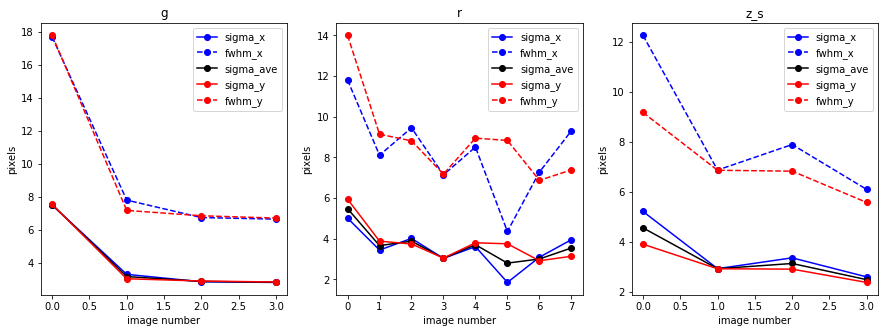

In [29]:
fig = plt.figure(figsize=(15,5))

for idx, key in enumerate(sigmas.keys()):
    ax=plt.subplot(1,3,idx+1)
    ax.plot(sigmas_2Dx[key], 'bo-', label='sigma_x')
    ax.plot(np.array(sigmas_2Dx[key])*2.355, 'bo--',label='fwhm_x')
    sigma_ave=(np.array(sigmas_2Dx[key])+np.array(sigmas_2Dy[key]))/2
    ax.plot(sigma_ave, 'ko-', label='sigma_ave')
    ax.plot(sigmas_2Dy[key], 'ro-', label='sigma_y')
    ax.plot(np.array(sigmas_2Dy[key])*2.355, 'ro--',label='fwhm_y')
    ax.set_title(key)
    ax.set_xlabel('image number')
    ax.set_ylabel('pixels')
    ax.legend()
    

## radial profile

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


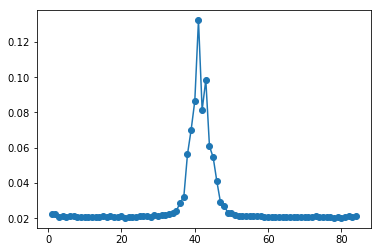

In [51]:
import numpy as np

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

rad_prof=radial_profile(img_crop, (img_crop.shape[0],img_crop.shape[1]))
plt.plot(rad_prof,'o-')

alternatively, fit a model to the radial profile above; might not correctly give the sigma/fwhm though

### Moffat

## aperture photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)


for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)


try `aperture_photometry( ... ,method='subpixel', subpixels=5)` for subpixel accucacy.

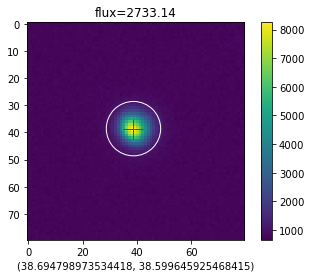

In [60]:
import numpy as np

sample_img = pf.open(bands['z_s'][0])[0].data
centroid = centroids_z[0]
boxsize=80
#crop
img_crop=utils.get_crop(sample_img,centroid,box_size=boxsize)
recentroid = phot.get_centroid(img_crop, method='2D_gaussian')
#photometry
aperture = CircularAperture(recentroid, r=10) 
result = aperture_photometry(img_crop, aperture) #,method='subpixel', subpixels=5)
flux = float(result['aperture_sum']/aperture.area())

plt.imshow(img_crop)
plt.xlabel(recentroid)
plt.title('flux={:.2f}'.format(flux))
plt.colorbar()
plt.plot(recentroid[0],recentroid[1],'+', c='r', ms=20, lw=10)
aperture.plot(color='w')

In [210]:
aperture_photometry??

## estimate and subtract sky background

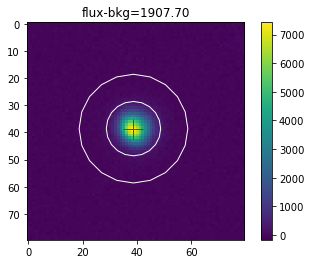

In [64]:
from photutils import CircularAnnulus

#photometry
aperture = CircularAperture(recentroid, r=10) 
phot_result = aperture_photometry(img_crop, aperture)
flux = float(phot_result['aperture_sum']/aperture.area())

annulus = CircularAnnulus(recentroid, r_in=10., r_out=20.)
ann_result = aperture_photometry(img_crop, annulus)
bkg_mean = float(ann_result['aperture_sum'] / annulus.area())

res=flux-bkg_mean
plt.imshow(img_crop-bkg_mean)
plt.title('flux-bkg={:.2f}'.format(res))
plt.colorbar()
plt.plot(recentroid[0],recentroid[1],'+', c='r', ms=20, lw=10)
annulus.plot(color='w')

## count as a function of r

In [164]:
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAnnulus
from moscatel import models

sample_img = pf.open(bands['z_s'][0])[0].data
centroid = centroids_z[0]
boxsize=80
annulus_width = 5 #pix
dr = 3 #
n =2 #inner radius of annulus = n*fwhm
inner_r=n*fwhm_mean


sums, fluxes, bkgs, diff = [], [], [], []

#crop
img_crop=utils.get_crop(sample_img,centroid,box_size=boxsize)
recentroid = phot.get_centroid(img_crop, method='2D_gaussian')

#fwhm
g = models.model_gaussian2D(img_crop)
fwhm_mean = 2.355*np.abs((g.x_stddev.value+g.y_stddev.value)/2)

radii = range(int(inner_r),img_crop.shape[0]-annulus_width,dr)

#photometry
for radius in radii:
    aperture=CircularAperture(recentroid, radius)
    annulus = CircularAnnulus(recentroid, r_in=radius, r_out=radius+annulus_width)
    summ=aperture_photometry(img_crop, aperture)['aperture_sum'][0]
    sums.append(summ)
    fluxes.append(aperture_photometry(img_crop, aperture)['aperture_sum'][0]/aperture.area())
    bkg=aperture_photometry(img_crop, annulus)['aperture_sum'][0]
    bkgs.append(bkg/annulus.area())
    diff.append(summ - bkg * aperture.area() / annulus.area())

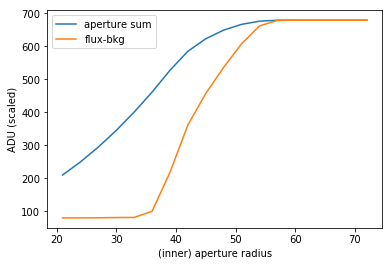

In [168]:
plt.plot(radii,sums,label='aperture sum')
plt.plot(radii,diff,label='flux-bkg')
plt.legend(loc='best')
plt.xlabel('(inner) aperture radius')
plt.ylabel('ADU')

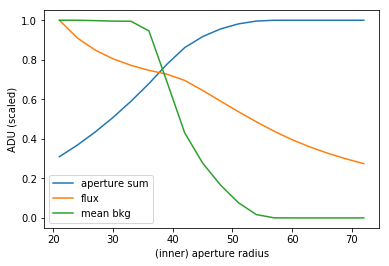

In [165]:
plt.plot(radii,sums/np.max(sums),label='aperture sum')
plt.plot(radii,fluxes/np.max(fluxes),label='flux')
plt.plot(radii,bkgs/np.max(bkgs),label='mean bkg')
plt.legend(loc='best')
plt.xlabel('(inner) aperture radius')
plt.ylabel('ADU (scaled)')

## compute uncertainty; std within annulus

## compute peak flux within aperture

## Manual point retrieval per band (g-r-z) and point source (3)

loop over `idx` and `band` for centroid/point source and g

In [81]:
phot.get_centroid??

In [82]:
centroid,recentroid

((911.39188437197015, 246.12980190879145),
 (18.691774488926832, 18.601491601238237))

In [31]:
from moscatel import *
from tqdm import tqdm
from datetime import datetime as dt

def make_lightcurve(band_idx):
    for star_idx in range(3):
        xcenters, ycenters = [],[]
        aperture_sums = []
        obs_time = []
        obs_mjd = []
        fwhm = []
        sum_per_band = {}

        ##extract lightcurve (enumerate all frames) in a given band
        for i in tqdm(bands[band_idx]):
            hdr = pf.open(i)[0].header
            img = pf.open(i)[0].data

            #get dates from fits header
            date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
            time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
            newdate = time.replace(year=date.year, month=date.month, day=date.day)
            obs_time.append(newdate)
            obs_mjd.append(hdr['MJD-STRT'])
            
            #crop
            image_crop = utils.get_crop(img, centroids[star_idx], box_size)
            #compute centroid
            centroid = phot.get_centroid(image_crop)
            centroids.append(centroid)

            xcenters.append(centroid[0])
            ycenters.append(centroid[1])
            
            #do photometry
            aperture_sum = phot.get_phot(image_crop, centroid, r=20)
            aperture_sums.append(aperture_sum)

            #fwhm
            fwhm.append(get_fwhm(image_crop))
            #fwhm.append(get_fwhm_2D(image_crop))
            
        #output as dataframe of given band and star
        dfs.append(pd.DataFrame(
            {'{0}_{1}_x'.format(band_name[band_idx], star_names[star_idx]) : xcenters,
             '{0}_{1}_y'.format(band_name[band_idx], star_names[star_idx]) : ycenters,
             '{0}_{1}_flux'.format(band_name[band_idx], star_names[star_idx]) : aperture_sums,
             '{0}_{1}_fwhm'.format(band_name[band_idx], star_names[star_idx]) : fwhm},
            index = obs_time))
        
    return dfs, band_idx

In [32]:
gband = bands['g']
rband = bands['r']
zband = bands['z_s']

bands = [gband,rband,zband]

TypeError: list indices must be integers or slices, not str

In [33]:
import pandas as pd
#import multiprocessing

box_size = 80


band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]
#centroids = centroid_xy[:3]
star_names = 'abc'

dfs = []

##loop in 3 stars given band  
dfs, band_idx =  make_lightcurve(band_idx=2)

  0%|          | 0/376 [00:00<?, ?it/s]/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 376/376 [00:04<00:00, 78.67it/s]


/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/pandas-0.19.2-py3.6-linux-x86_64.egg/pandas/tools/plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


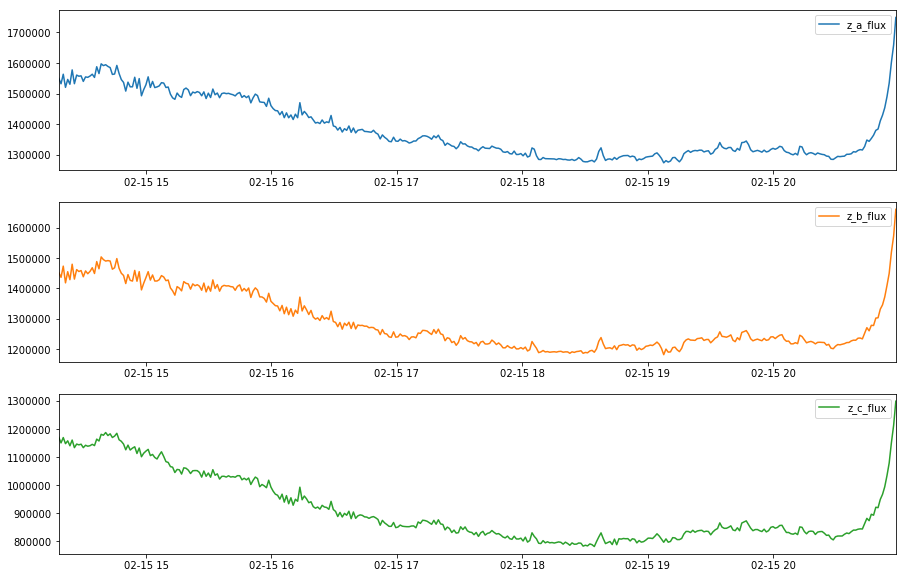

In [34]:
#plot fluxes
df = plotting.plot_lightcurve(dfs, band_idx)

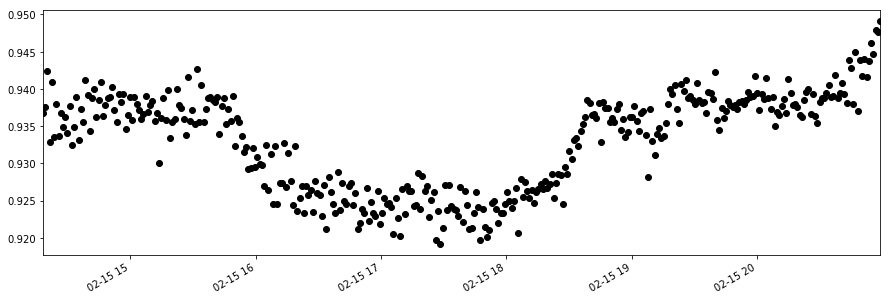

In [35]:
(df['z_b_flux'] / df['z_a_flux']).plot(figsize=(15,5), color='k', marker='o', linestyle='none')

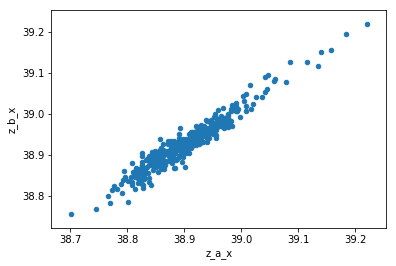

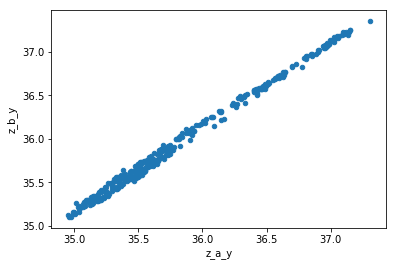

In [36]:
df.plot.scatter(*'z_a_x z_b_x'.split())
df.plot.scatter(*'z_a_y z_b_y'.split())

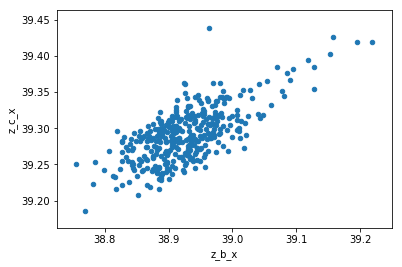

In [37]:
df.plot.scatter(*'z_b_x z_c_x'.split())

## Centroid

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f46d77054e0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f467d0ee2b0>], dtype=object)

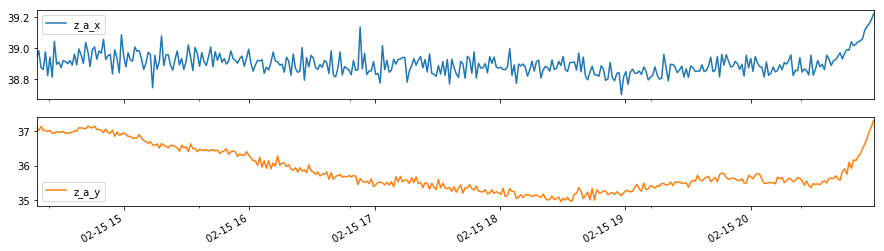

In [38]:
cols = 'z_a_x z_a_y'.split()
df[cols].plot(subplots=True, figsize=(15,4))

## FWHM

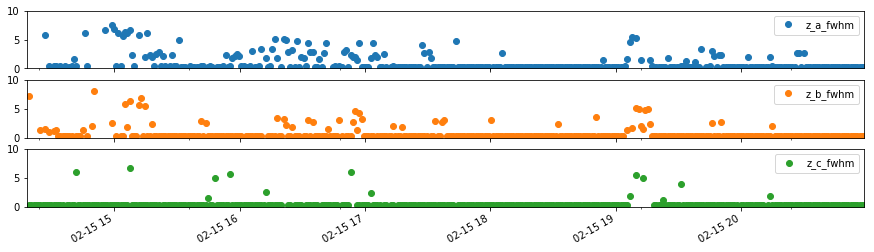

In [39]:
cols = 'z_a_fwhm z_b_fwhm z_c_fwhm'.split()
df[cols].plot(subplots=True, figsize=(15,4), ylim=(0,10), marker='o', linestyle='');

In [ ]:
a = df['z_a_fwhm']
a_filtered = a[a<10] 
plt.plot(a_filtered, 'o')

## Relative photometry

In [ ]:
f = (df['z_b_flux'] / df['z_a_flux']).values
f /= np.median(f)

In [ ]:
t = df.index.to_julian_date().values

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(t, f, 'ko')

## MLE

In [ ]:
def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

tc = t.mean()
p = 4.3
k = np.sqrt(0.015)
i = np.pi/2
t14 = 2.8/24
u1 = 0.4
u2 = 0.4
a = scaled_a(p, t14, k, i=np.pi/2)
# ls = np.log(f.std())
# k0 = 0
# theta = [k,tc,a,i,u1,u2,ls,k0]
theta = [k,tc,a,i,u1,u2]
print ("initial guess: {}".format(theta))

In [ ]:
from pytransit import MandelAgol
MA = MandelAgol()

def model_u(theta, t, p):
    k,tc,a,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a, i)
    return m

plt.plot(t, f, 'ko', t, model_u(theta, t, p), 'r-')

In [ ]:
import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

print ("cost before: {}".format(obj(theta, t, p, f)))
res = op.minimize(obj, theta, args=(t, p, f), method='nelder-mead')
print ("cost after: {}".format(obj(res.x, t, p, f)))

In [ ]:
plt.plot(t, f, 'ko', t, model_u(res.x, t, p), 'r-')

In [ ]:
xcenter = df['z_a_x']
ycenter = df['z_a_y']

#fwhm = xcenter*ycenter
fwhm = df['z_a_fwhm']

In [ ]:
np.c_[fwhm, xcenter, ycenter].shape

In [ ]:
df['z_a_fwhm'].head()#.query('5<a<10')

### Systematic Model

In [ ]:
ls = np.log(f.std())
k0, k1, k2, k3, k4 = 0,0,0,0,0
theta = [k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4] #add sys params

def model_s(theta, fwhm, xcenter, ycenter, t):
    a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    dummy = np.ones(len(fwhm))
    s = (np.array(theta)*np.c_[fwhm, xcenter, ycenter, t, dummy]).sum(axis=1)
    return s

def loglike(theta, t, f, p, fwhm, xcenter, ycenter, ret_mod=False, ret_sys=False, ret_full = False):
    ls = theta[6]
    m = model_u(theta[:6], t, p)
    s = model_s(theta[7:], fwhm, xcenter, ycenter, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

nll = lambda *x: -loglike(*x)

print ("NLL before: {}".format(nll(theta, t, f, p, fwhm, xcenter, ycenter)))
res = op.minimize(nll, theta, args=(t, f, p, fwhm, xcenter, ycenter), method='powell')
print ("NLL after: {}".format(nll(res.x, t, f, p, fwhm, xcenter, ycenter)))

In [ ]:
%timeit model_s(range(5), fwhm, xcenter, ycenter, t)

In [ ]:
%timeit model_u(theta[:6], t, p)

In [ ]:
plt.plot(t, f, 'ko', t, loglike(res.x, t, f, p, fwhm, xcenter, ycenter, ret_full=True), 'r-')

## Maximum A Priori Estimation

In [ ]:
def logprob(theta, t, f, p, fwhm, xcenter, ycenter, up=None):

    k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4 = theta

    if u1 < 0 or u1 > 2 or u2 < -1 or u2 > 1 or k < 0 or k > 1 or i > np.pi/2:
        return -np.inf

    lp = 0
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    ll = loglike(theta, t, f, p, fwhm, xcenter, ycenter)

    if np.isnan(ll).any():
        return -np.inf
    
    return lp + ll


nlp = lambda *x: -logprob(*x)

print ("NLP before: {}".format(nlp(theta, t, f, p, fwhm, xcenter, ycenter)))
res = op.minimize(nlp, theta, args=(t, p, f, fwhm, xcenter, ycenter), method='nelder-mead')
print ("NLP after: {}".format(nlp(res.x, t, f, p, fwhm, xcenter, ycenter)))

In [ ]:
plt.plot(t, f, 'ko', t, loglike(res.x, t, f, p, fwhm, xcenter, ycenter, ret_full=True), 'r-')

## MCMC

In [ ]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p, fwhm, xcenter, ycenter
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)

pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

## Parameter best estimates

In [ ]:
for i,j in zip(theta, sampler.flatchain.mean(axis=0)): 
    print(i,j)

In [ ]:
sampler.flatlnprobability.shape

In [ ]:
sampler.flatchain.shape

In [ ]:
sampler.flatlnprobability.max()

In [ ]:
max_idx=np.argmax(sampler.flatlnprobability)

In [ ]:
#parameter vector
pv=sampler.flatchain[max_idx]
pv

## Modelling results

In [ ]:
import seaborn as sb

chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    ax.set_ylim()

Monitor the [Gelman-Rubin statistic]() to ensure high quality posterior samples for the chains produced by the MCMC sampler 

* stabilize below a typical value of at most 1.03 up to a maximum of N steps for each of the N walkers
* cull the final chain using the burn-in value of N and thinning by a factor of 10 to account for autocorrelation in samples
* the final flattened chains thus consist of approximately X independent posterior samples

In [ ]:
burn = 500

In [ ]:
#nwalkers, nsteps, ndim
sampler.chain.shape

In [ ]:
sampler.chain[:,burn:,:].shape

In [ ]:
sampler.chain[:,burn:,:].reshape(-1, ndim).shape

In [ ]:
fc=sampler.chain[:,burn:,:].reshape(-1, ndim)

In [ ]:
ps = [loglike(pv, t, f, p, fwhm, xcenter, ycenter, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

with sb.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        ax.plot(t, s, 'r-', alpha=0.03)
    plt.setp(ax, xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))

In [ ]:
import corner
with sb.axes_style('white'):
    corner.corner(fc, labels='k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4'.split(','))

In [ ]:
import seaborn as sb
#modeling+systematics
with sb.axes_style('ticks'):
    for s in ps:
        plt.plot(t, s, 'r-', alpha=0.03)

In [ ]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(2, 1, figsize=(15,8))
    #data
    ax[0].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        #model
        ax[0].plot(t, loglike(pv, t, f, p, fwhm, xcenter, ycenter, ret_mod=True), 
                   'b-', alpha=0.03) 
        #model+systematics
        ax[0].plot(t, s, 'r-', alpha=0.03)
    #residual
    res = loglike(pv, t, f, p, fwhm, xcenter, ycenter, ret_full=True)
    ax[1].plot(f-res, 'r-', label='residual')
    plt.setp(ax[0], xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))
ax[0].legend(['data','model','data+sys'], loc='lower left')
ax[1].legend(loc='best')

## To Do:

* fwhm
* peak flux within aperture of brightest star